In [1]:
# Librairies import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings


from project_functions import *

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Clustering Librairies import
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [2]:
data = pd.read_pickle('data_clients.pickle')

In [3]:
data.head()

,customer_unique_id,date_last_order,days_last_order,nb_orders,total_spend,mean_price_order,mean_review_score,total_items,mean_nb_items,zip_code
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1481,1,129.90,129.90,5.0,1,1.0,7787
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1483,1,18.90,18.90,4.0,1,1.0,6053
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1906,1,69.00,69.00,3.0,1,1.0,88115
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1690,1,25.99,25.99,4.0,1,1.0,66812
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1657,1,180.00,180.00,5.0,1,1.0,18040


# Segmentation RFM

Pour la première modélisation je sélectionne les features correspondantes à une segmentation RFM qui prend en compte :
- La **récence d'achat**, exprimée en nombre de jours depuis la date actuelle (`days_last_order`)
- Le **nombre de commandes effectuées** sur la période totale, correspondant à sa **fréquence d'achat** (`nb_orders`)
- La **dépense totale** (`total_spend`)

In [4]:
X_rfm = data[["days_last_order","nb_orders","total_spend"]].copy()
X_rfm.head()

,days_last_order,nb_orders,total_spend
0,1481,1,129.90
1,1483,1,18.90
2,1906,1,69.00
3,1690,1,25.99
4,1657,1,180.00


## **Preprocessing**

In [5]:
scaler = MinMaxScaler()
X_rfm_scaled = scaler.fit_transform(X_rfm)

On va utiliser plusieurs algorithmes de clustering, afin d'évaluer le meilleur modèle à utiliser.

**On va tester les algorithmes suivants :**
   - K-means
   - DBSCAN

**Les critères de comparaison sont les suivants :**

- Des clusters denses mais séparés entre eux
- Score moyen de silhouette (qui doit être maximal)
- Le temps d'entrainement

## **K-means**

### **Inertia**

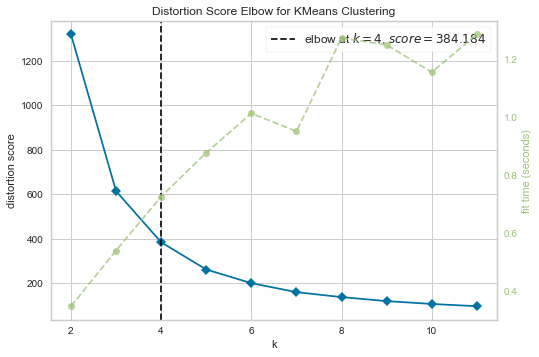

In [6]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

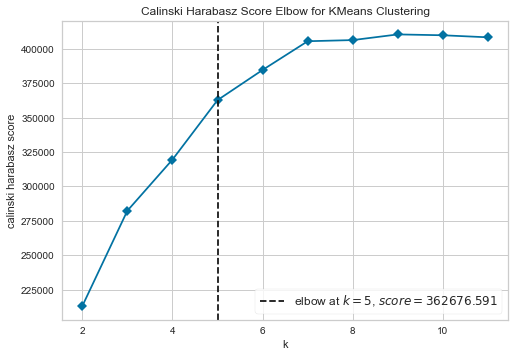

In [7]:
# Instantiate the clustering model and visualizer 
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', timings=False)

visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

Il semble que l'on obtienne un clustering efficace pour une valeur de k compris entre 4 et 6 inclus.

### **Silhouette diagram**

``` python
for k in range(2,7):
    # Instantiate the clustering model and visualizer 
    model = KMeans(k)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data
    plt.show()
```

En affichant les silhouettes pour chaque k grâce au code ci-dessus (long à executer), Il semble que l'on obtienne un clustering optimal pour k=4 ou k=3, car le score de silhouette est maximal. 

Je choisi k=4 en me fiant à la méthode du coude et la silhouette

### Distance intercluster

In [8]:
model = KMeans(4, random_state=0)

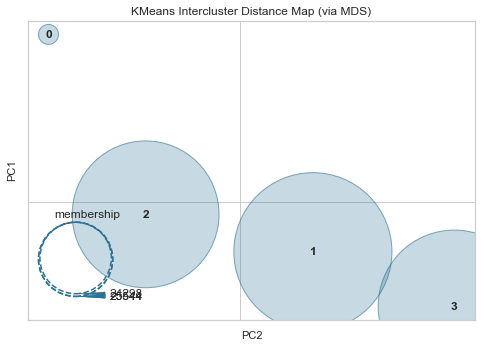

In [9]:
visualizer = InterclusterDistance(model)
visualizer.fit(X_rfm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

Les clusters ne semblent pas correctement  tous bien séparés entre eux.

### Visualisation t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 93358 samples in 0.084s...
[t-SNE] Computed neighbors for 93358 samples in 2.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93358
[t-SNE] Computed conditional probabilities for sample 2000 / 93358
[t-SNE] Computed conditional probabilities for sample 3000 / 93358
[t-SNE] Computed conditional probabilities for sample 4000 / 93358
[t-SNE] Computed conditional probabilities for sample 5000 / 93358
[t-SNE] Computed conditional probabilities for sample 6000 / 93358
[t-SNE] Computed conditional probabilities for sample 7000 / 93358
[t-SNE] Computed conditional probabilities for sample 8000 / 93358
[t-SNE] Computed conditional probabilities for sample 9000 / 93358
[t-SNE] Computed conditional probabilities for sample 10000 / 93358
[t-SNE] Computed conditional probabilities for sample 11000 / 93358
[t-SNE] Computed conditional probabilities for sample 12000 / 93358
[t-SNE] Computed conditional probabilities for sa

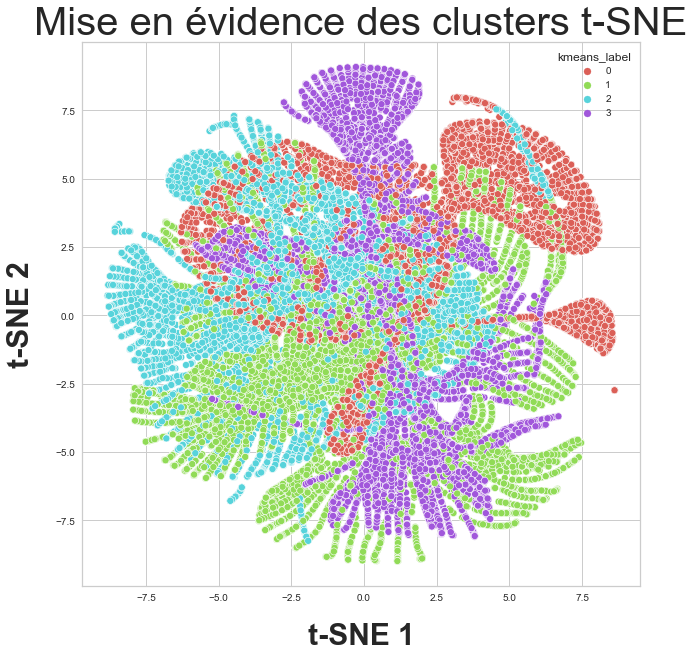

In [10]:
k_means_label = model.labels_
plotTSNE(X_rfm_scaled, k_means_label)

### Synthèse, meilleur score

In [11]:
algo = {"K-Means": model}

k_means_score =  algo_score(algo, X_rfm_scaled)
k_means_score

,algorithme,silhouette,nb_clusters,time_sec
0,K-Means,0.529994,4,0.66


### Interprétation métier des clusters 

In [12]:
X_rfm["kmeans_label"] = k_means_label

In [13]:
X_rfm

,days_last_order,nb_orders,total_spend,kmeans_label
0,1481,1,129.90,3
1,1483,1,18.90,3
2,1906,1,69.00,0
3,1690,1,25.99,2
4,1657,1,180.00,2
...,...,...,...,...
93353,1816,1,1570.00,0
93354,1631,1,64.89,2
93355,1937,1,89.90,0
93356,1488,1,115.00,3


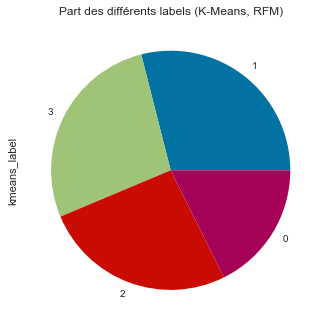

In [14]:
X_rfm.kmeans_label.value_counts().plot.pie()
plt.title("Part des différents labels (K-Means, RFM)")
plt.show()

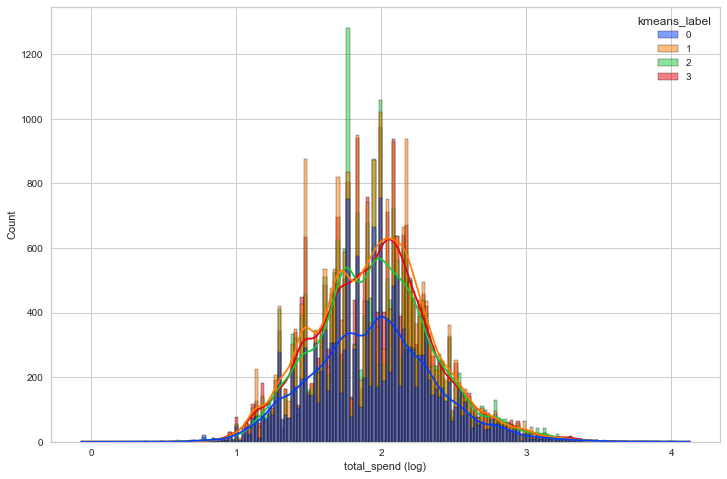

In [89]:
plt.figure(figsize=(12,8))
sns.histplot(data=X_rfm, x=np.log10(X_rfm["total_spend"]), hue="kmeans_label", kde=True, palette="bright")
plt.xlabel('total_spend (log)')
plt.show()

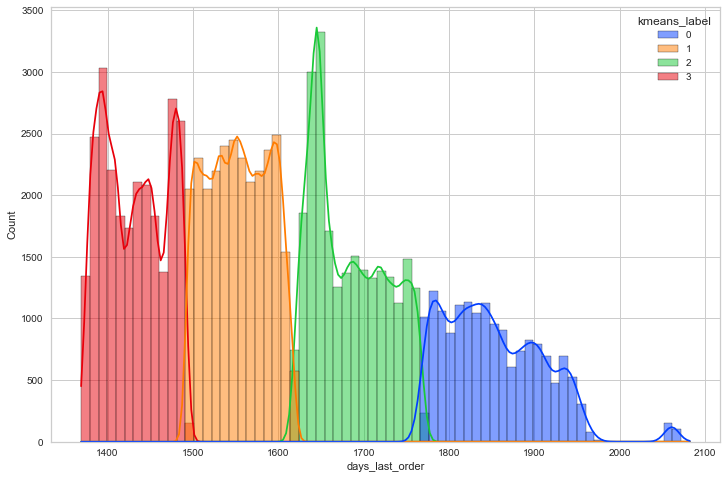

In [16]:
plt.figure(figsize=(12,8))
sns.histplot(data=X_rfm, x=X_rfm["days_last_order"], hue="kmeans_label", kde=True, palette="bright")
plt.show()

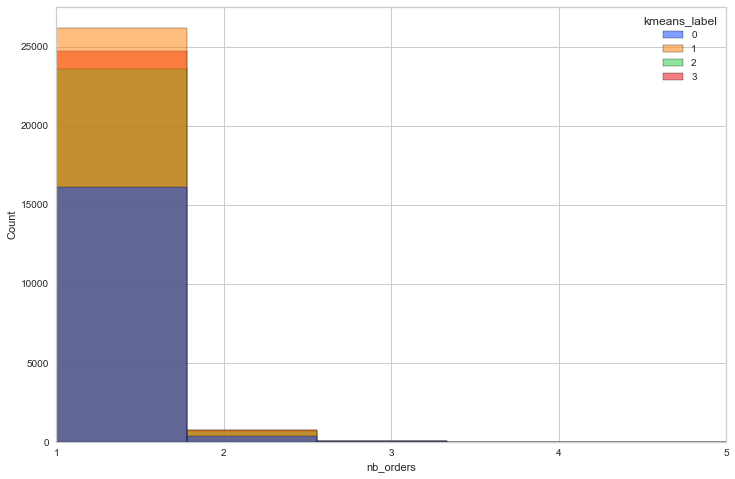

In [17]:
plt.figure(figsize=(12,8))
sns.histplot(data=X_rfm, x=(X_rfm["nb_orders"]), hue="kmeans_label", palette="bright")
plt.xlim(1,5)
plt.xticks([1,2,3,4,5])
plt.show()

In [18]:
X_rfm.groupby("kmeans_label").mean()

,days_last_order,nb_orders,total_spend
kmeans_label,,,
0,1852.976144,1.024706,151.019330
1,1553.135530,1.035168,144.305885
2,1683.536011,1.031937,150.115686
3,1431.437128,1.038600,150.279854


In [19]:
X_rfm.groupby("kmeans_label").median()

,days_last_order,nb_orders,total_spend
kmeans_label,,,
0,1844.0,1.0,89.900
1,1553.0,1.0,89.900
2,1677.0,1.0,89.900
3,1431.0,1.0,90.445


On observe une segmentation clair des différents clusters sur la variable lié à la récence.

Par exemple : 

- Label = 1 : clients qui ont achetés le plus "recemment".
- Label = 2 : clients qui ont achetés le moins recemment. Ce qui explite le cluster très éloignés sur la visualisation MSD

Il est cependant impossible de segmenter les clients à l'aide des autres variables. La segmentation RFM ne semble pas efficace dans ce cas de figure. Ceci peut être expliqué par le fait que les clients n'ont commandés qu'une seule fois. Nous réaliserons plus une tard une segmentation sur l'ensemble des variables, pour voir ci cela permet d'améliorer le clustering.

**Essayons de voir l'impact du nombre de commande sur les clusters en sélectionnant les clients qui ont passés plus d'une commande :** 

In [20]:
X_rfm_multiple_orders = X_rfm[X_rfm.nb_orders >= 2]
X_rfm_multiple_orders.head()

,days_last_order,nb_orders,total_spend,kmeans_label
104,1597,2,317.89,1
243,1457,2,81.45,3
305,1895,2,199.60,0
404,1502,2,182.90,1
419,1564,2,183.43,1


In [21]:
X_rfm_multiple_orders.groupby("kmeans_label").mean()

,days_last_order,nb_orders,total_spend
kmeans_label,,,
0,1844.513228,2.076720,289.323175
1,1553.186541,2.122786,288.777367
2,1683.445833,2.077778,297.300861
3,1432.323598,2.151869,291.567488


In [22]:
X_rfm_multiple_orders.groupby("kmeans_label").median()

,days_last_order,nb_orders,total_spend
kmeans_label,,,
0,1833.5,2.0,179.93
1,1554.0,2.0,204.80
2,1678.0,2.0,199.79
3,1433.0,2.0,199.80


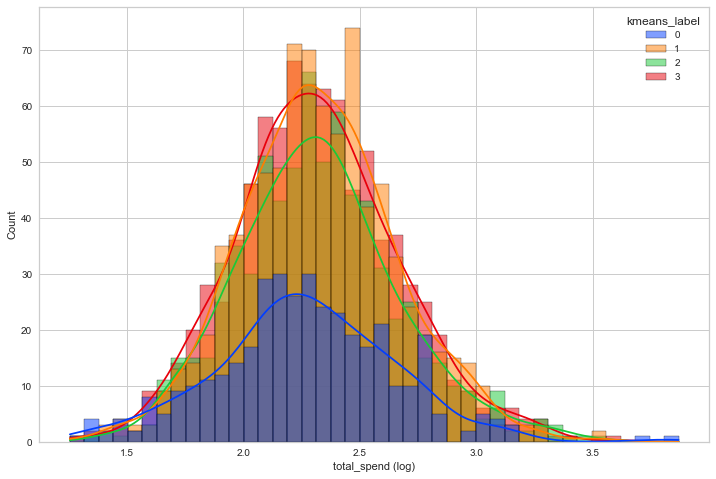

In [23]:
plt.figure(figsize=(12,8))
sns.histplot(data=X_rfm_multiple_orders, x=np.log10(X_rfm_multiple_orders["total_spend"]), hue="kmeans_label", kde=True, palette="bright")
plt.xlabel('total_spend (log)')
plt.show()

Il semblerait que les clients dans le cluster 2, dépense moins et sont ceux qui ont commandés il y a le plus longtemps.

## DBSCAN

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

Observons le score de silhouette pour diférentes valeur de l'hyperparamètre eps: 

```python
range_eps = np.arange(0.1, 0.5, 0.1)
silhouette_values = []
for eps in range_eps:
    print("eps value is :"+str(eps))
    db = DBSCAN(eps=eps).fit(X_rfm_scaled)
    labels = db.labels_
    silhouette_avg = silhouette_score(X_rfm_scaled,labels)
    silhouette_values.append(silhouette_avg)
    print("Silhouette score : ", silhouette_avg)


plt.plot(range_eps, silhouette_values)
plt.title("Hyperparameter eps tuning")
plt.xlabel('eps')
plt.ylabel('silhouette coefficient value')
plt.show()
```

On executant le code ci-dessus (long) on obtient un **eps** optimal (valeur ou le score de silhouette est maximale) pour une valeur égale à 0.40

``` python 
dbs_model = DBSCAN(eps = 0.4)
algo = {"DBSCAN": dbs_model}

dbscan_score = algo_score(algo, X_rfm_scaled)
dbscan_score
```

In [25]:
#X_rfm["dbscan_label"] = dbs_model.labels_

In [26]:
#X_rfm.dbscan_label.value_counts()

L'algorithme DBSCAN réalise un clustering de 2 clusters. En observant la proportion de clients dans chaque cluster on remarque une anomalie. Seulement 1 client est inclu dans un cluster, et tous les autres clients dans un autre cluster. De plus, l'algorithme est très couteux en temps. (plus de 7min pour entrainer le model)

scatter plot (r-m)

## Test de segmentation RFM en sélectionnant uniquement les clients qui ont passés plus d'une commande (k-means)

In [27]:
X_rfm_test = data[["days_last_order","nb_orders","total_spend"]].copy()
X_rfm_test.head()

,days_last_order,nb_orders,total_spend
0,1481,1,129.90
1,1483,1,18.90
2,1906,1,69.00
3,1690,1,25.99
4,1657,1,180.00


In [28]:
X_rfm_test = X_rfm_test[X_rfm_test.nb_orders >= 2]
X_rfm_test.head()

,days_last_order,nb_orders,total_spend
104,1597,2,317.89
243,1457,2,81.45
305,1895,2,199.60
404,1502,2,182.90
419,1564,2,183.43


In [29]:
X_rfm_test.shape

(2801, 3)

In [30]:
X_rfm_test.nb_orders.value_counts()

2     2573
3      181
4       28
5        9
6        5
7        3
9        1
15       1
Name: nb_orders, dtype: int64

In [31]:
X_rfm_test_scaled = scaler.fit_transform(X_rfm_test)

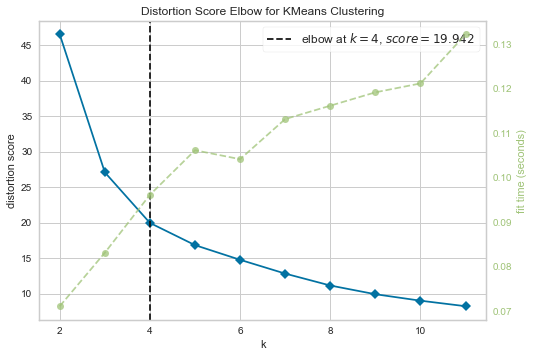

In [32]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_rfm_test_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

In [33]:
model = KMeans(4, random_state=0)

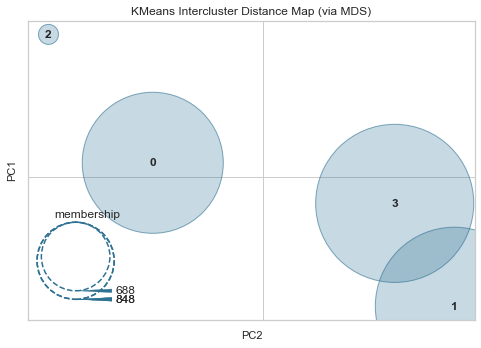

In [34]:
visualizer = InterclusterDistance(model)
visualizer.fit(X_rfm_test_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

In [35]:
k_means_label = model.labels_

In [36]:
X_rfm_test["k_means_labels"] = k_means_label

In [37]:
X_rfm_test.head()

,days_last_order,nb_orders,total_spend,k_means_labels
104,1597,2,317.89,3
243,1457,2,81.45,1
305,1895,2,199.60,2
404,1502,2,182.90,3
419,1564,2,183.43,3


In [38]:
X_rfm_test.groupby("k_means_labels").median()

,days_last_order,nb_orders,total_spend
k_means_labels,,,
0,1672.0,2.0,199.795
1,1432.5,2.0,200.000
2,1825.0,2.0,184.895
3,1553.0,2.0,204.780


pairplot (x_scaled)

Cluster 2, clients qui dépensent légèrement moins que les autres, et qui ont commandé il y a le plus longtemps.

Le résultat semble identique au processus précèdent qui impliqué de faire une segmentation sur l'ensemble des clients puis une sélection des clients qui ont passés commandes plusieurs fois.

**Nous allons maintenant utiliser l'algorithme de K-Means sur l'ensemble des variables. K-means offre les meilleurs résultats pour un temps d'entrainement beaucoup moindre.**

# Segmentation sur l'ensemble des variables

## Preprocessing

Je sélectionne les variables numériques, et je supprime les variables `total_spend`,`total_items` car comme on l'a vu dans l'EDA elles sont très correlées à `mean_price_order`, `mean_nb_items` étant donné que la majorité des clients ont passé qu'une seule commande.

In [39]:
X = data.drop(["customer_unique_id","date_last_order","zip_code","mean_price_order","total_items"],axis=1).copy()
X.head()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items
0,1481,1,129.90,5.0,1.0
1,1483,1,18.90,4.0,1.0
2,1906,1,69.00,3.0,1.0
3,1690,1,25.99,4.0,1.0
4,1657,1,180.00,5.0,1.0


In [40]:
X.shape

(93358, 5)

In [41]:
X.dtypes

days_last_order        int32
nb_orders              int64
total_spend          float64
mean_review_score    float64
mean_nb_items        float64
dtype: object

In [42]:
X.isna().sum()

days_last_order        0
nb_orders              0
total_spend            0
mean_review_score    603
mean_nb_items          0
dtype: int64

In [43]:
X.dropna(inplace=True)

In [44]:
X.shape

(92755, 5)

In [45]:
X.isna().sum()

days_last_order      0
nb_orders            0
total_spend          0
mean_review_score    0
mean_nb_items        0
dtype: int64

In [46]:
X_scaled = scaler.fit_transform(X)

## Inertia 

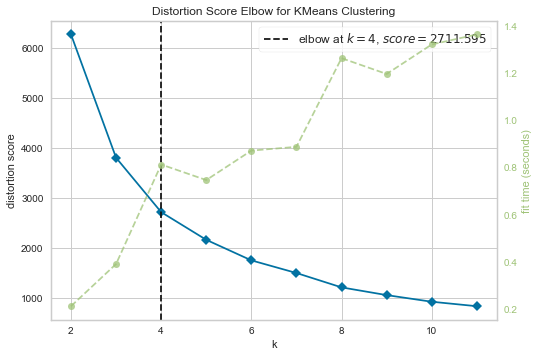

In [47]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

## Silhouette diagram

```python
for k in range(2,7):
    # Instantiate the clustering model and visualizer 
    model = KMeans(k)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(X_rfm_scaled)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data
    plt.show()
```

En affichant les silhouettes pour chaque k grâce au code ci-dessus (long à executer), Il semble que l'on obtienne un clustering optimal pour k=4, car le score de silhouette est maximal.

## Distance intercluster

In [48]:
model = KMeans(4, random_state=0)

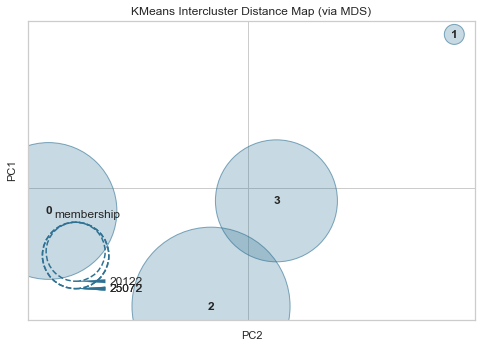

In [49]:
visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

La séparation des clusters en utilisant l'ensemble des variables semble identique à une segmentation RFM. On a la même difficulté à séparer nettement les différents groupes.

## Visualisation t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 92755 samples in 0.126s...
[t-SNE] Computed neighbors for 92755 samples in 5.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 92755
[t-SNE] Computed conditional probabilities for sample 2000 / 92755
[t-SNE] Computed conditional probabilities for sample 3000 / 92755
[t-SNE] Computed conditional probabilities for sample 4000 / 92755
[t-SNE] Computed conditional probabilities for sample 5000 / 92755
[t-SNE] Computed conditional probabilities for sample 6000 / 92755
[t-SNE] Computed conditional probabilities for sample 7000 / 92755
[t-SNE] Computed conditional probabilities for sample 8000 / 92755
[t-SNE] Computed conditional probabilities for sample 9000 / 92755
[t-SNE] Computed conditional probabilities for sample 10000 / 92755
[t-SNE] Computed conditional probabilities for sample 11000 / 92755
[t-SNE] Computed conditional probabilities for sample 12000 / 92755
[t-SNE] Computed conditional probabilities for sa

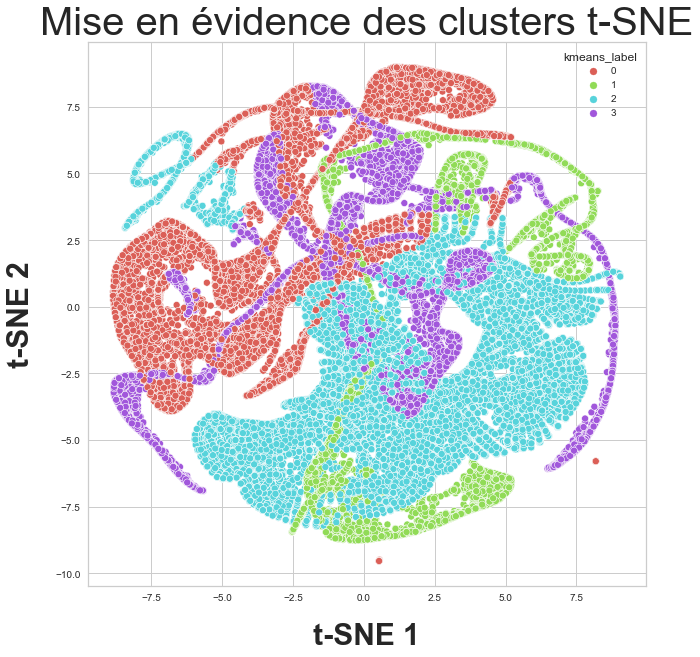

In [50]:
k_means_label = model.labels_
plotTSNE(X_scaled, k_means_label)

## Interprétation métier des clusters 

In [51]:
X["kmeans_label"] = k_means_label

In [52]:
X.head()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items,kmeans_label
0,1481,1,129.90,5.0,1.0,2
1,1483,1,18.90,4.0,1.0,3
2,1906,1,69.00,3.0,1.0,0
3,1690,1,25.99,4.0,1.0,3
4,1657,1,180.00,5.0,1.0,0


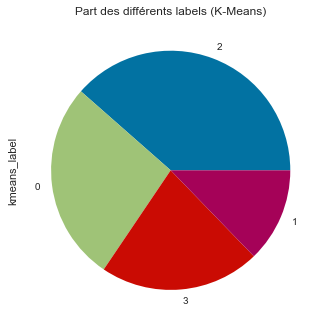

In [53]:
X.kmeans_label.value_counts().plot.pie()
plt.title("Part des différents labels (K-Means)")
plt.show()

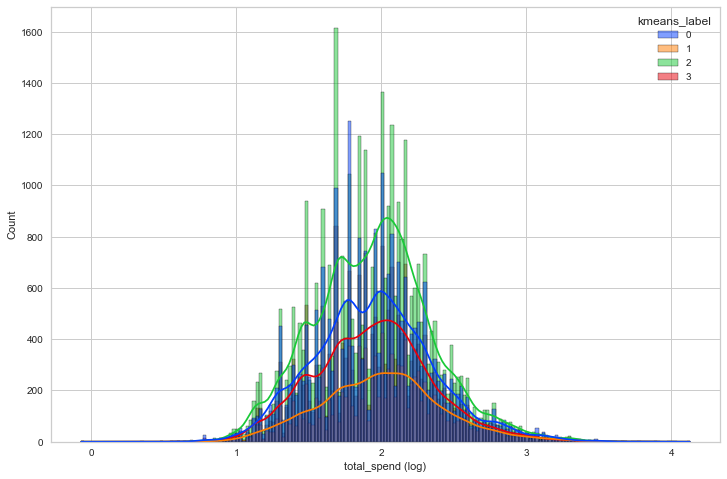

In [88]:
plt.figure(figsize=(12,8))
sns.histplot(data=X, x=np.log10(X["total_spend"]), hue="kmeans_label", kde=True, palette="bright")
plt.xlabel('total_spend (log)')
plt.show()

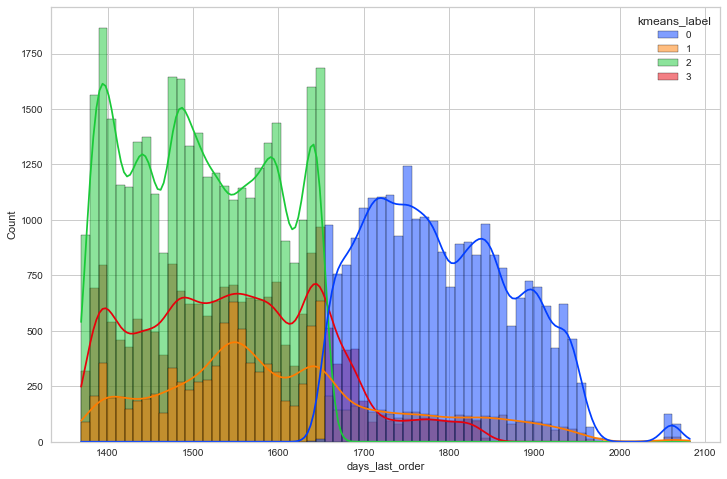

In [87]:
plt.figure(figsize=(12,8))
sns.histplot(data=X, x=X["days_last_order"], hue="kmeans_label", kde=True, palette="bright")
plt.show()

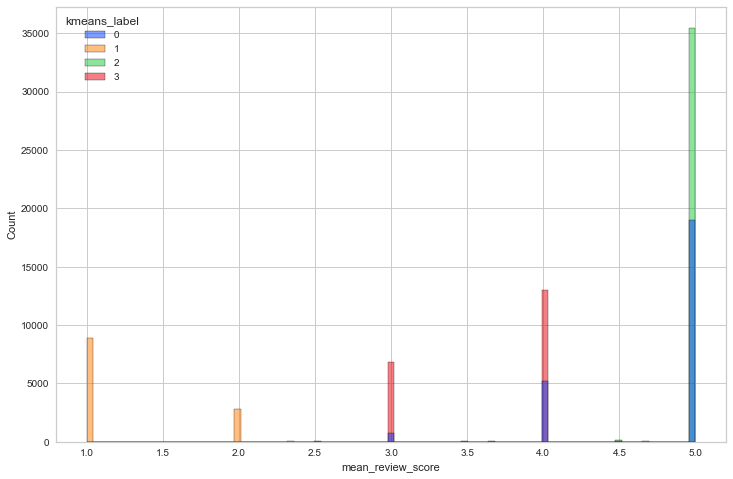

In [86]:
plt.figure(figsize=(12,8))
sns.histplot(data=X, x=X["mean_review_score"], hue="kmeans_label", palette="bright")
plt.show()

In [57]:
X.groupby("kmeans_label").mean()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items
kmeans_label,,,,,
0,1791.748843,1.028478,149.917823,4.726564,1.057707
1,1605.930460,1.023236,172.538144,1.247156,1.158043
2,1508.945138,1.037732,142.969122,4.996813,1.052446
3,1549.320992,1.038465,141.875702,3.650956,1.066581


In [58]:
X.groupby("kmeans_label").median()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items
kmeans_label,,,,,
0,1782.0,1.0,89.9,5.0,1.0
1,1580.0,1.0,99.9,1.0,1.0
2,1504.0,1.0,89.9,5.0,1.0
3,1546.0,1.0,89.7,4.0,1.0


- Le cluster 0 semble indiquer des clients qui ont commandés il y a longtemps, qui dépense comme les autres clients mais qui sont très satisfait.
- Le cluster isolé numéro 1 semble indiqué une segmentation des clients sur la note moyenne, qui est très faible dans ce cas la. Cependant, les clients dans ce cluster semble dépenser plus que les autres.
- Le cluster 2 semble indiquer des clients qui ont commandés le plus recemment, pour une dépense moindre que les autres clients mais qui sont globalement satisfait.
- Le cluster 3 semble indiquer des clients qui ont commandés assez recemment, pour une dépense moyenne, et qui sont très satisfait. Ils representent la majorité des clients.

## Test de segmentation en sélectionnant uniquement les clients qui ont passés plus d'une commande (k-means)

In [59]:
X_test = X[X.nb_orders >= 2]
X_test.head()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items,kmeans_label
104,1597,2,317.89,5.000000,1.000000,2
243,1457,2,81.45,4.000000,1.000000,3
305,1895,2,199.60,4.000000,1.000000,0
404,1502,2,182.90,3.500000,1.000000,3
419,1564,2,183.43,4.333333,1.333333,3


In [60]:
X_test = X_test.drop("kmeans_label",axis=1)
X_test.head()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items
104,1597,2,317.89,5.000000,1.000000
243,1457,2,81.45,4.000000,1.000000
305,1895,2,199.60,4.000000,1.000000
404,1502,2,182.90,3.500000,1.000000
419,1564,2,183.43,4.333333,1.333333


In [61]:
X_test.shape

(2792, 5)

In [62]:
X_test.nb_orders.value_counts()

2     2564
3      181
4       28
5        9
6        5
7        3
9        1
15       1
Name: nb_orders, dtype: int64

In [63]:
X_test_scaled = scaler.fit_transform(X_test)

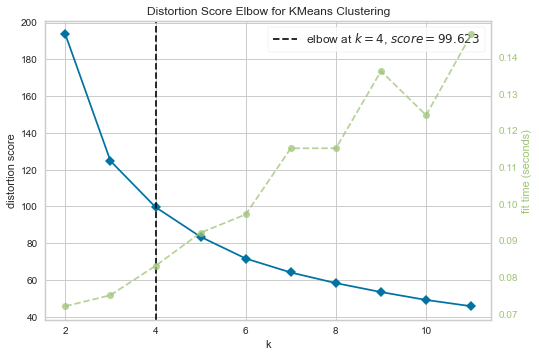

In [64]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_test_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()

In [65]:
model = KMeans(4, random_state=0)

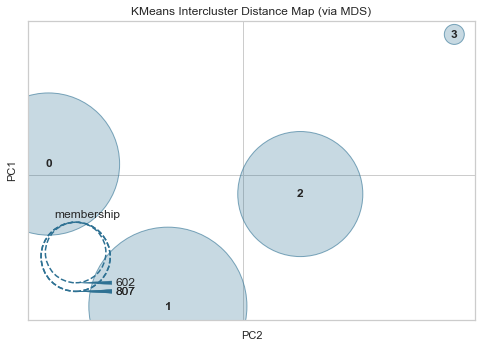

In [66]:
visualizer = InterclusterDistance(model)
visualizer.fit(X_test_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2792 samples in 0.003s...
[t-SNE] Computed neighbors for 2792 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2792
[t-SNE] Computed conditional probabilities for sample 2000 / 2792
[t-SNE] Computed conditional probabilities for sample 2792 / 2792
[t-SNE] Mean sigma: 0.023014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.627018
[t-SNE] KL divergence after 300 iterations: 0.858954


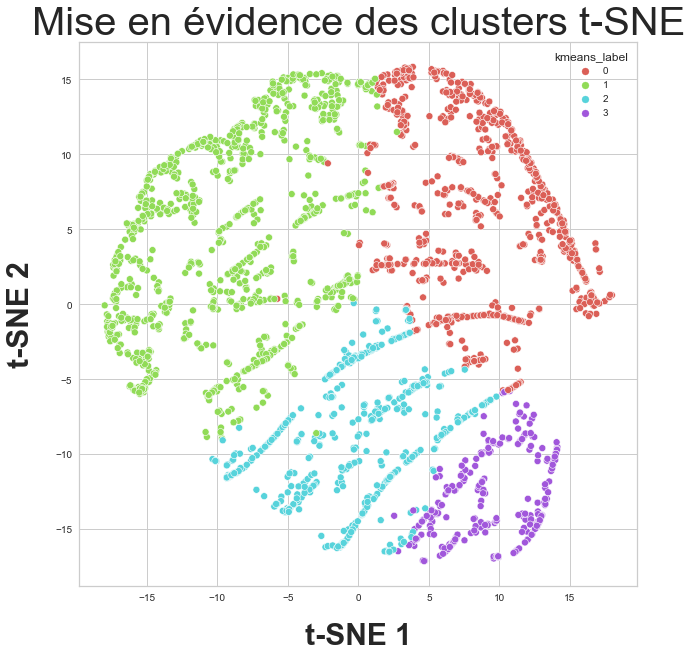

In [67]:
k_means_label = model.labels_
plotTSNE(X_test_scaled, k_means_label)

Le clustering semble bien plus efficace.

In [68]:
X_test["k_means_labels"] = k_means_label

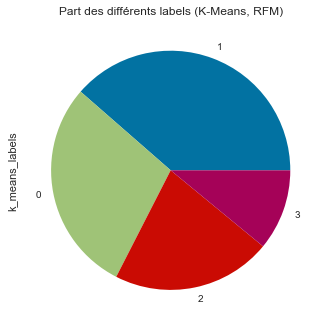

In [69]:
X_test.k_means_labels.value_counts().plot.pie()
plt.title("Part des différents labels (K-Means, RFM)")
plt.show()

In [70]:
X_test.head()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items,k_means_labels
104,1597,2,317.89,5.000000,1.000000,1
243,1457,2,81.45,4.000000,1.000000,2
305,1895,2,199.60,4.000000,1.000000,0
404,1502,2,182.90,3.500000,1.000000,2
419,1564,2,183.43,4.333333,1.333333,1


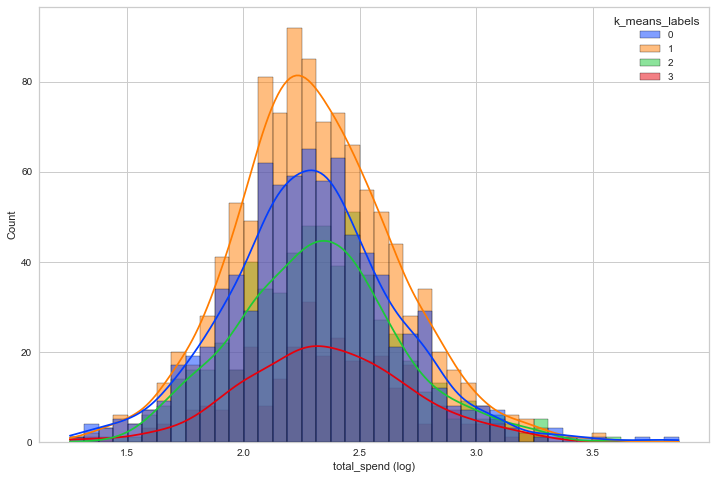

In [85]:
plt.figure(figsize=(12,8))
sns.histplot(data=X_test, x=np.log10(X_test["total_spend"]), hue="k_means_labels", kde=True, palette="bright")
plt.xlabel('total_spend (log)')
plt.show()

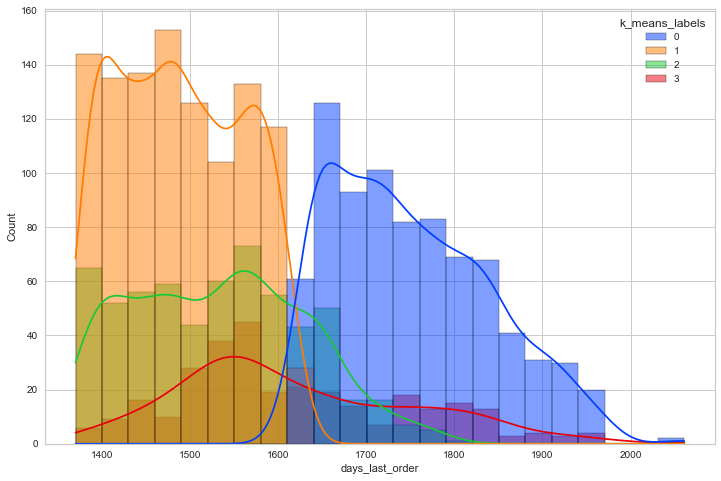

In [84]:
plt.figure(figsize=(12,8))
sns.histplot(data=X_test, x=X_test["days_last_order"], hue="k_means_labels",kde=True, palette="bright")
plt.show()

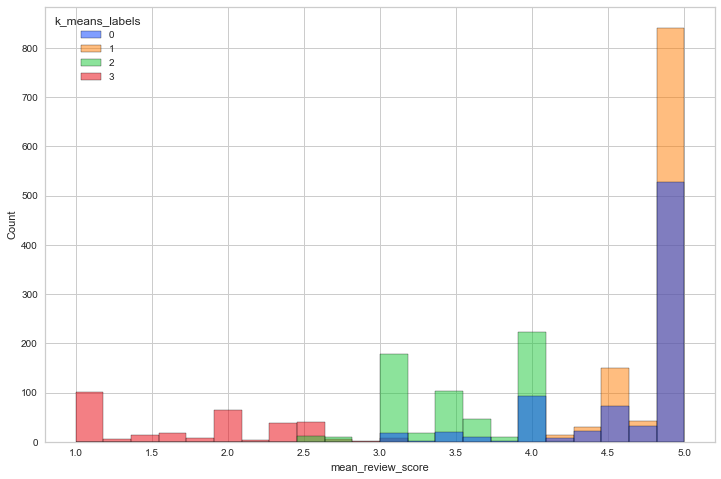

In [95]:
plt.figure(figsize=(12,8))
sns.histplot(data=X_test, x=X_test["mean_review_score"], hue="k_means_labels", palette="bright")
plt.show()

In [74]:
X_test.groupby("k_means_labels").mean()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items
k_means_labels,,,,,
0,1752.141264,2.089219,291.899009,4.697624,1.110992
1,1489.197772,2.152275,282.056769,4.890426,1.123537
2,1532.205980,2.109635,294.915100,3.517394,1.140908
3,1619.735294,2.055556,318.098856,1.767076,1.286777


In [75]:
X_test.groupby("k_means_labels").median()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items
k_means_labels,,,,,
0,1737.0,2.0,194.890,5.0,1.0
1,1485.0,2.0,191.990,5.0,1.0
2,1538.5,2.0,208.560,3.5,1.0
3,1584.5,2.0,223.345,2.0,1.0


Label 0 : Clients qui ont commandés il y a longtemps mais qui sont très satisfait.

Label 1: Clients qui ont commandés récemment et qui sont très satisfait mais qui dépensent moins.

Label 2: Clients qui ont commandés assez récemment mais qui sont moyennement satisfait.

Label 3: Clients qui ont commandés assez récemment et qui dépensent le plus mais qui sont peu satisfait.

In [76]:
X_test.head()

,days_last_order,nb_orders,total_spend,mean_review_score,mean_nb_items,k_means_labels
104,1597,2,317.89,5.000000,1.000000,1
243,1457,2,81.45,4.000000,1.000000,2
305,1895,2,199.60,4.000000,1.000000,0
404,1502,2,182.90,3.500000,1.000000,2
419,1564,2,183.43,4.333333,1.333333,1


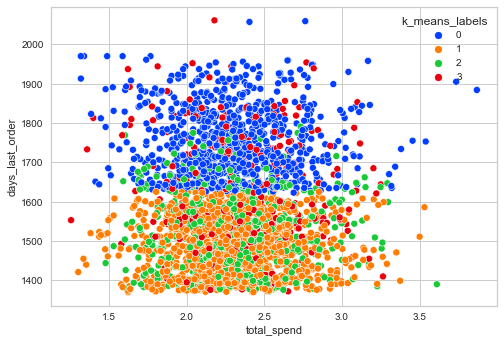

In [82]:
sns.scatterplot(data=X_test, x=np.log10(X_test["total_spend"]), y="days_last_order", hue="k_means_labels", palette="bright")
plt.show()

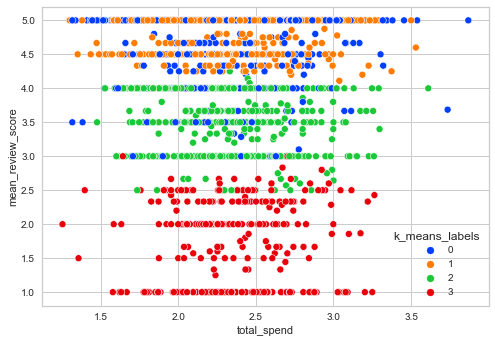

In [80]:
sns.scatterplot(data=X_test, x=np.log10(X_test["total_spend"]), y="mean_review_score", hue="k_means_labels", palette="bright")
plt.show()

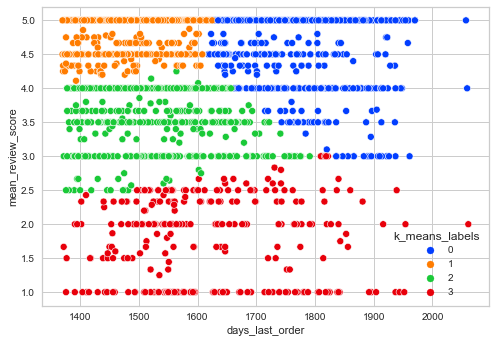

In [81]:
sns.scatterplot(data=X_test, x="days_last_order", y="mean_review_score", hue="k_means_labels", palette="bright")
plt.show()

---